# Модель машинного обучения для детекции и предотвращения мошенничества в кредитных операциях

**Автор: Кузьмин Дмитрий**

# Проблема мошеннических операций

Мошенничество существует с тех пор, как существует человечество, и может принимать бесконечное множество различных форм. Кроме того, развитие новых технологий предоставляет преступникам дополнительные способы совершения мошенничества, например, в электронной коммерции

Использование кредитных карт широко распространено в современном обществе, и мошенничество с кредитными картами неуклонно растет в последние годы. Финансовые потери из-за мошенничества затрагивают не только банки, но и отдельных клиентов. Если банк теряет деньги, клиенты в конечном итоге тоже платят через более высокие процентные ставки, повышенные членские взносы и т.д.

Обнаружение мошенничества — это процесс определения, принадлежит ли новая авторизованная транзакция к мошенническим или подлинным транзакциям, исходя из набора кредитных карт транзакций. Система обнаружения мошенничества (FDS) должна не только эффективно выявлять случаи мошенничества, но и быть экономически эффективной в том смысле, что стоимость, затрачиваемая на проверку транзакций, не должна превышать потери от мошенничества.

Техники машинного обучения базируются на выводе модели предсказания на основе набора примеров. Эта модель, чаще всего параметрическая функция, позволяет предсказывать вероятность того, что транзакция является мошенничеством, на основе набора характеристик, описывающих транзакцию. В области обнаружения мошенничества использование техник обучения привлекательно по ряду причин. 

1. Они позволяют обнаруживать закономерности в данных с высокой размерностью, т.е. транзакции поступают в виде непрерывного потока и каждая транзакция определяется многими переменными.
2. Мошеннические транзакции часто коррелируют во времени и пространстве. Например, мошенники обычно пытаются совершить аферы в одном магазине с разными картами в течение короткого периода времени.
3. Методы обучения могут использоваться для обнаружения и моделирования существующих мошеннических стратегий, а также для выявления новых стратегий, связанных с необычным поведением владельцев карт.

Предсказательные модели, основанные на методах ML, также способны автоматически интегрировать обратную связь следователей для улучшения точности обнаружения, в то время как в случае экспертных систем включение обратной связи требует пересмотра правил, что может быть утомительным и трудоемким.


# О наборе данных 

Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт. Он содержит только числовые входные переменные, которые являются результатом преобразования PCA.

Он содержит 31 числовую входную переменную. Признак `Time` обозначает количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных. Признак `Amount` — сумма транзакции, которая может использоваться, например, в задачах обучения с учетом затрат.

Признак `Class` является целевой переменной и принимает значение 1 при мошенничестве и 0 — в противном случае.

Набор данных сильно несбалансирован: мошенничество составляет 0,172% от всех транзакций (492 мошеннические транзакции из 284 807). Также отсутствует идентификатор владельца карты, поэтому каждую транзакцию можно рассматривать как независимую от остальных.

Из-за дисбаланса классов наши модели классификации будут считать, что в большинстве случаев мошенничество отсутствует! Нам нужно, чтобы модель была уверена при выявлении мошенничества. Чтобы избежать переобучения мы будем использовать подвыборки для обучения модели. В этом случае наша подвыборка будет датафреймом с соотношением 50/50 мошеннических и немошеннических транзакций.

То есть будем использовать деление набора на train | test при помощи Кросс-Валидаций для того, чтобы избежать дисбаланса классов и обучать модели на подвыборках 50/50


## Импорт библиотек

In [1]:
import warnings, os, json, math, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import RobustScaler

## Чтение данных

In [2]:
df = pd.read_csv('../data/creditcard.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Предварительная очистка данных

### Пропущенные значения

In [7]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Ура, в нашем наборе нету пропущенных значений

### Дубликаты

In [22]:
print(f'Количество дубликатов в наборе данных: {df.duplicated().sum()}')

Количество дубликатов в наборе данных: 0


In [9]:
df = df.drop_duplicates()
df.shape

(283726, 31)

### Дисбаланс классов

In [18]:
df['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

D:\anaconda\envs\ml_course\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='count'>

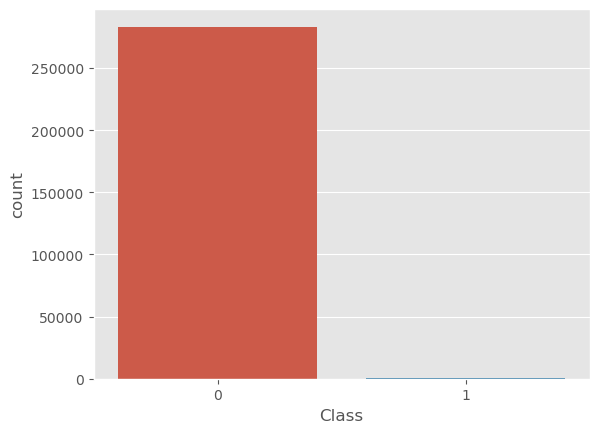

In [19]:
sns.countplot('Class', data=df)

Когда данные несбалансированы, стандартные алгоритмы машинного обучения, максимизирующие общую точность, склонны классифицировать все наблюдения как экземпляры большинства класса. Это приводит к низкой точности для меньшинственного класса

Обучение на несбалансированных наборах данных является сложной задачей, так как большинство алгоритмов обучения не предназначены для работы с большой разницей между числом случаев, принадлежащих к разным классам

### Выбросы

В задачах, подобных обнаружению мошенничества, выбросы часто и есть тот самый миноритарный класс, который мы хотим найти. Если мы будем относиться к выбросам без должной осторожности, то рискуем потерять важные данные для обучения нашей модели. Например, при удалении мошеннических транзакций на большую сумму наша модель перестает понимать, что мошенники способны переводить крупные суммы со счетов, то есть мы теряем тех самых "китов"

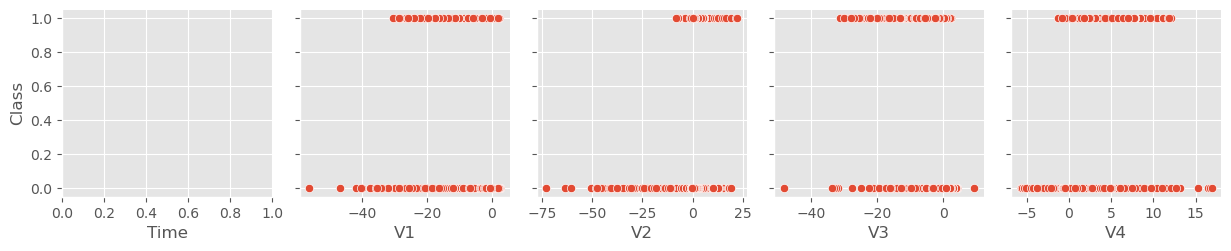

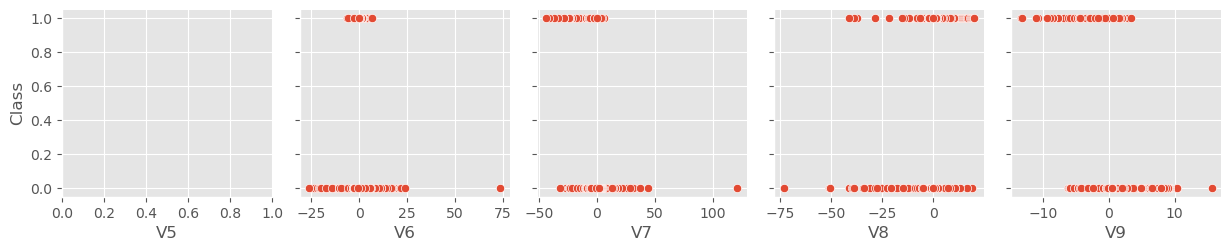

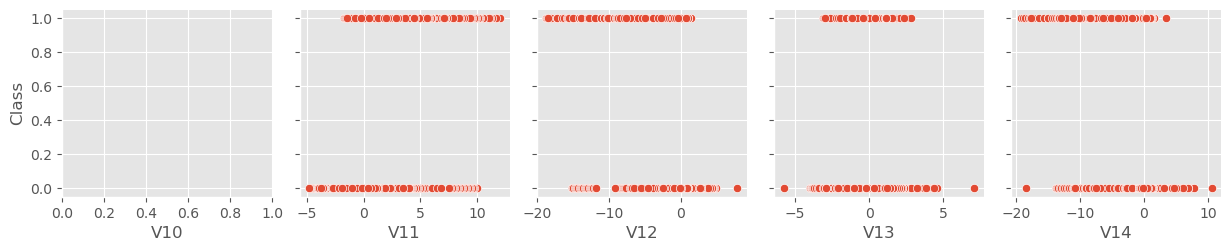

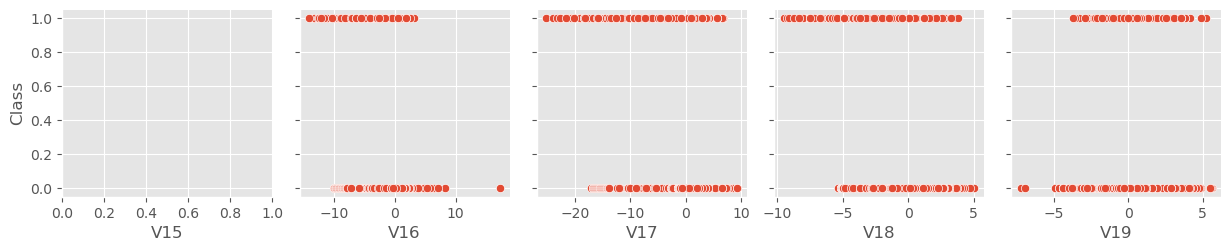

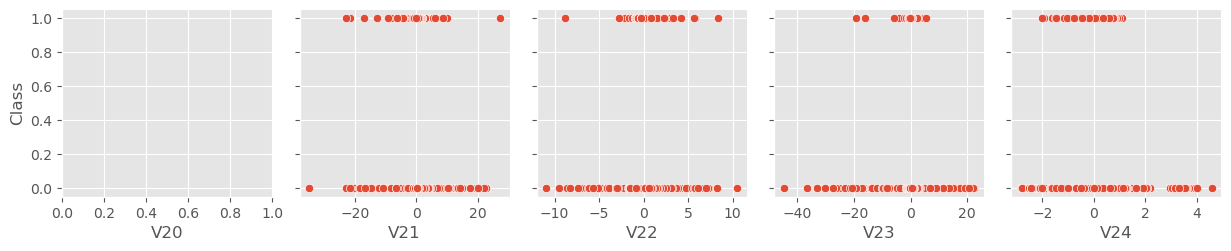

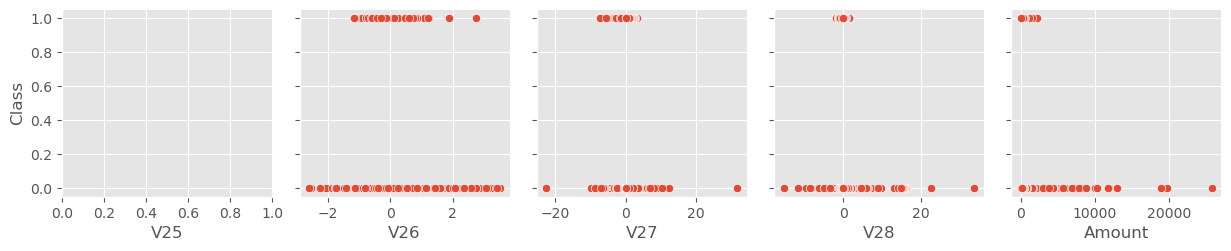

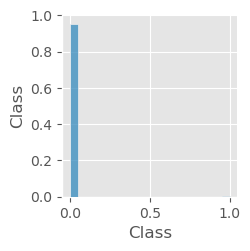

In [26]:
df_num = df.select_dtypes(exclude='object')
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Class'])

In [31]:
def find_outliers(df):
    outliers = []
    for col in df.select_dtypes(include=np.number):
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers.extend(df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)].index)
    return list(set(outliers))

In [40]:
outliers = find_outliers(df)
print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов от набора данных: {round(len(outliers)/len(df) * 100, 1)}%")

Количество выбросов: 137788
Процент выбросов от набора данных: 48.6%


Удалив выбросы, мы потеряем 48.6% очень важных данных. Мы не будем этого делать. Вместо этого мы будем использовать робастный алгоритмы для масштабирования признаков. RobustScaler помогает уменьшить влияние выбросов, сохраняя важную информацию в данных

## Оценка корреляций признаков с целевой переменной

In [42]:
df.corr()["Class"].sort_values()

V17      -0.313498
V14      -0.293375
V12      -0.250711
V10      -0.206971
V16      -0.187186
V3       -0.182322
V7       -0.172347
V18      -0.105340
V1       -0.094486
V9       -0.094021
V5       -0.087812
V6       -0.043915
Time     -0.012359
V24      -0.007210
V23      -0.006333
V13      -0.003897
V15      -0.003300
V25       0.003202
V26       0.004265
V22       0.004887
Amount    0.005777
V28       0.009682
V20       0.021486
V27       0.021892
V21       0.026357
V8        0.033068
V19       0.033631
V2        0.084624
V4        0.129326
V11       0.149067
Class     1.000000
Name: Class, dtype: float64

<AxesSubplot:title={'center':'Наиболее значимые признаки'}>

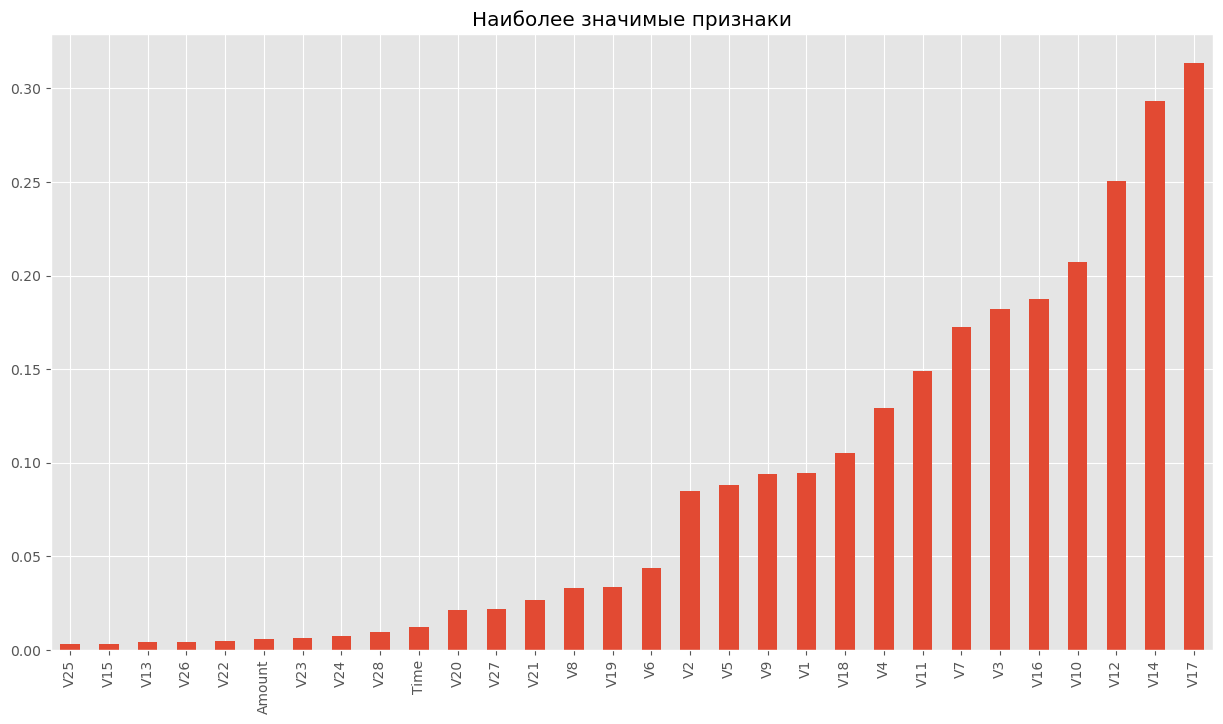

In [44]:
plt.figure(figsize=(15,8))
df.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Наиболее значимые признаки')

In [54]:
print(f" Наиболее значимые признаки в датасете: {list(df.corr()['Class'][df.corr()['Class'] < -0.15].index)}")

 Наиболее значимые признаки в датасете: ['V3', 'V7', 'V10', 'V12', 'V14', 'V16', 'V17']


## Визуализация данных

array([[<AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>,
        <AxesSubplot:title={'center':'V5'}>],
       [<AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>,
        <AxesSubplot:title={'center':'V8'}>,
        <AxesSubplot:title={'center':'V9'}>,
        <AxesSubplot:title={'center':'V10'}>,
        <AxesSubplot:title={'center':'V11'}>],
       [<AxesSubplot:title={'center':'V12'}>,
        <AxesSubplot:title={'center':'V13'}>,
        <AxesSubplot:title={'center':'V14'}>,
        <AxesSubplot:title={'center':'V15'}>,
        <AxesSubplot:title={'center':'V16'}>,
        <AxesSubplot:title={'center':'V17'}>],
       [<AxesSubplot:title={'center':'V18'}>,
        <AxesSubplot:title={'center':'V19'}>,
        <AxesSubplot:title={'center':'V20'}>,
        <AxesSubplot:title={'center':'V

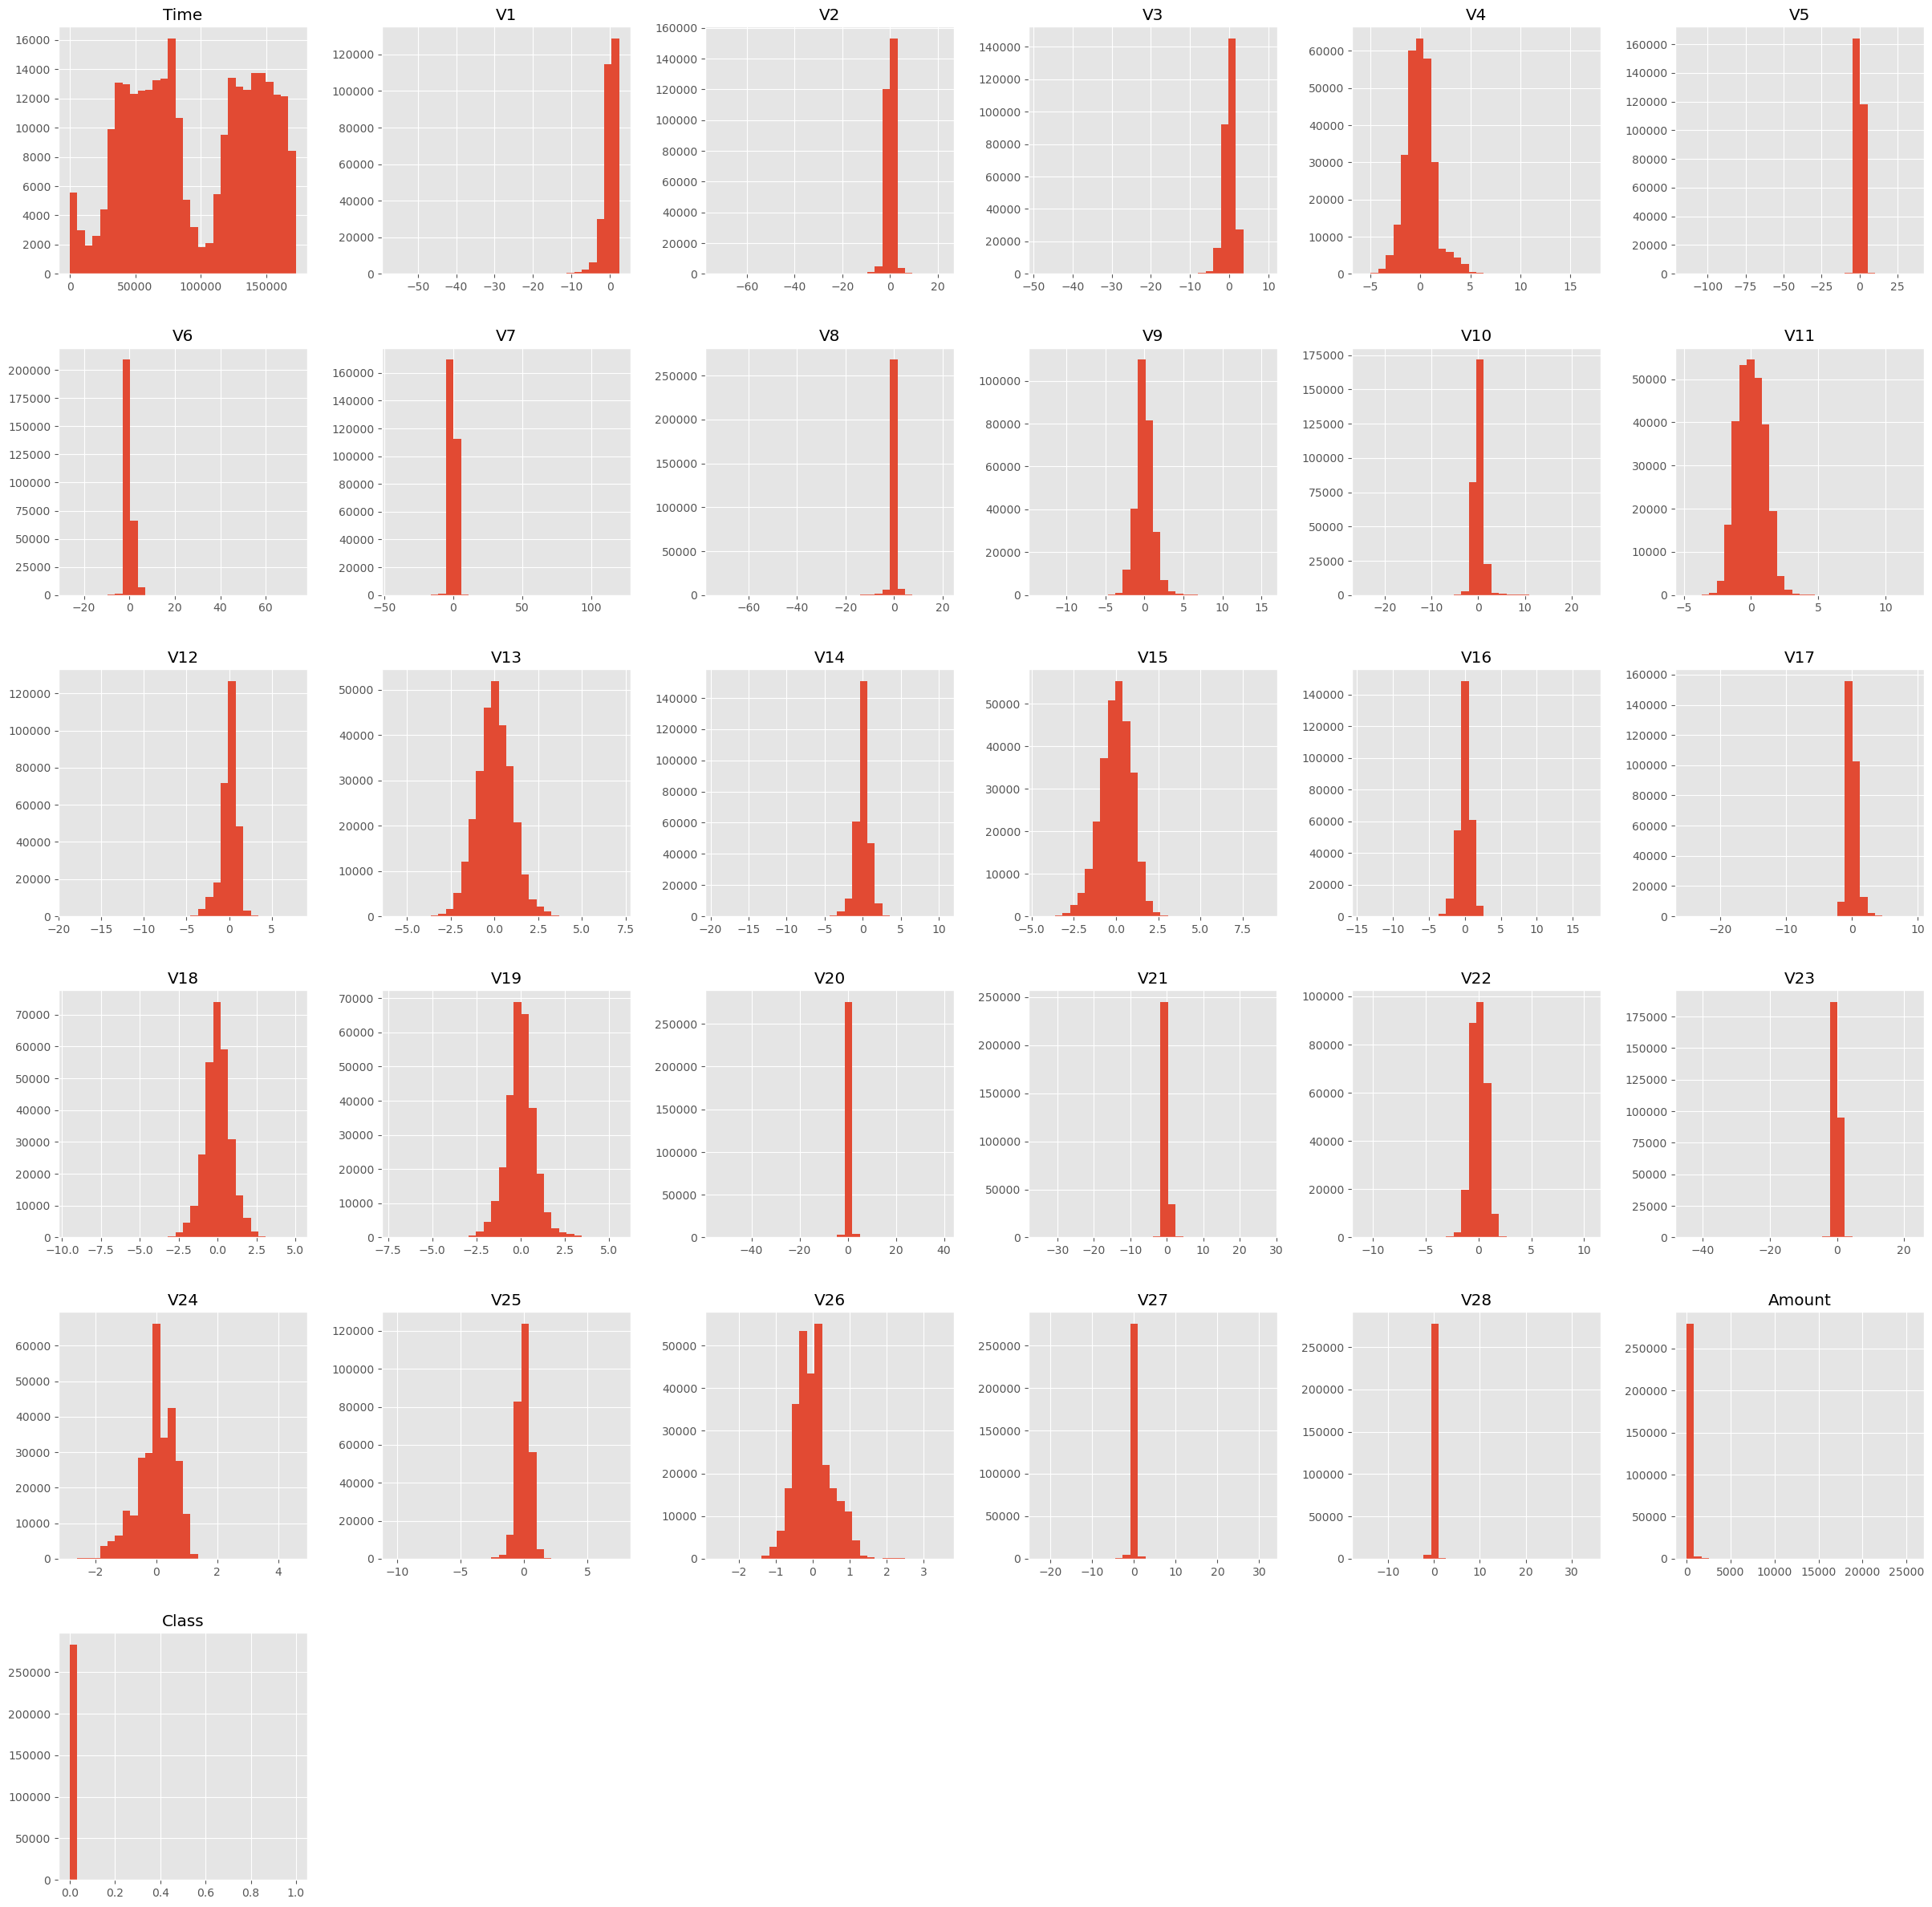

In [11]:
df.hist(bins=30, figsize=(30,30))

Text(0, 0.5, 'Class')

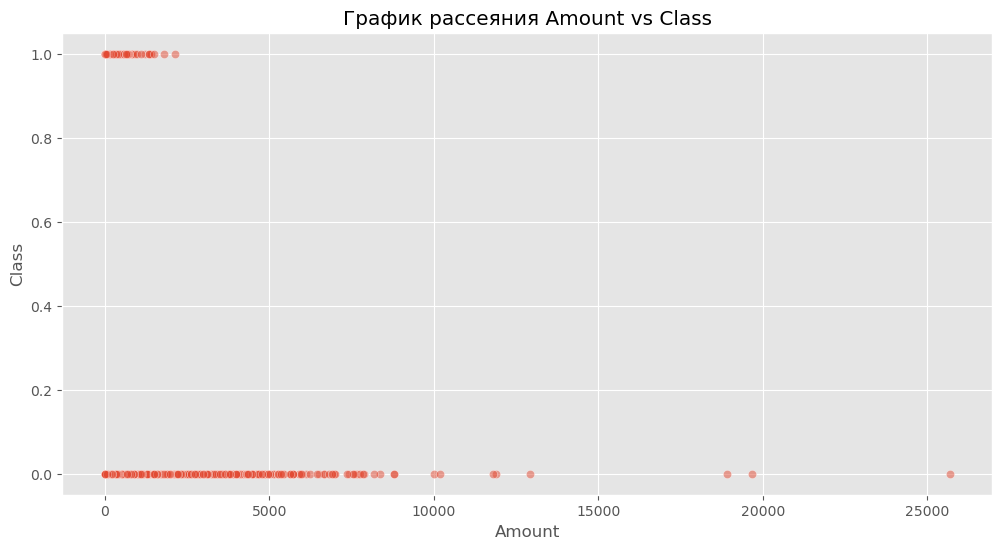

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Amount', y='Class', alpha=0.5)
plt.title('График рассеяния Amount vs Class')
plt.xlabel('Amount')
plt.ylabel('Class')

## Масштабирование признаков при помощи RobustScaler() и MinMax Scalling

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.774718,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.268530,0
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.959811,0
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.411487,0
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.667362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.999965,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.295230,0
284803,0.999971,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038798,0
284804,0.999977,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.638020,0
284805,0.999977,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.166875,0


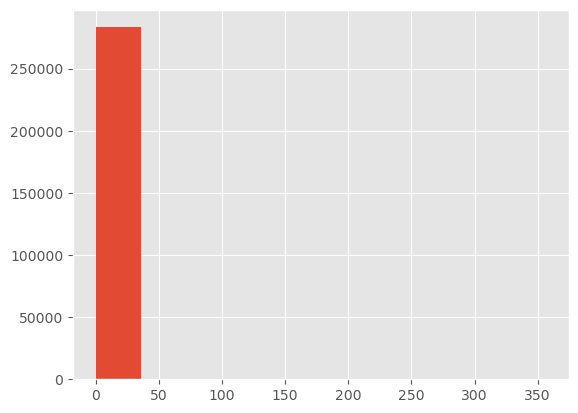

In [14]:
new_df = df.copy()
new_df['Amount'] = RobustScaler().fit_transform(new_df['Amount'].to_numpy().reshape(-1, 1))
new_df['Amount'].hist()
time = new_df['Time']
new_df['Time'] = (time - time.min()) / (time.max() - time.min())
new_df

In [15]:
new_df["Amount"].describe()

count    283726.000000
mean          0.924387
std           3.482123
min          -0.305938
25%          -0.228063
50%           0.000000
75%           0.771937
max         356.962314
Name: Amount, dtype: float64

## Построение модели машинного обучения

В работе...